# Algorithm comparison

The computations below compares fits to the same simulated data using two different methods to compute the fit residuals. The function `costfunlsq` computes $\mathbf{r}_\text{TLS}(\mathbf{\theta})$, defined in Eq. (29) of [Mohtashemi et al. (2021)](https://doi.org/10.1364/OE.417724). The function `costfuntls` computes the residual vector
$$\mathbf{r}(\mathbf{\theta}, \mathbf{\mu}) = [\mathbf{\delta}(\mathbf{\mu}), \mathbf{\epsilon}(\mathbf{\theta}, \mathbf{\mu})], $$
where
$$[\mathbf{\delta}(\mathbf{\mu})]_k = \frac{x_k - \mu_k}{\sigma_{xk}$$
and
$$[\mathbf{\epsilon}(\mathbf{\theta}, \mathbf{\mu})]_k = \frac{y_k - f_k(\mathbf{\theta}, \mathbf{\mu})}{\sigma_{yk}.$$

In [1]:
import numpy as np
from numpy import pi
from numpy.fft import rfftfreq, rfft, irfft
from numpy.random import default_rng

import scipy.linalg as la
from scipy.optimize import least_squares
from scipy.stats import cumfreq, chi2, norm, probplot

from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

from thztools import thzgen, noiseamp, costfunlsq, costfuntls

## Simulate set of noisy waveforms

In [2]:
n = 256  # Number of samples
ts = 0.05  # Sampling time [ps]
t0 = 2.5  # Peak pulse time [ps]
fs = 1 / ts  # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0  # RNG seed
rng = default_rng(seed)

The transfer function model function `tf_model` returns
 $$ H(\mathbf{\theta}; \omega) = \theta_0\exp(-i\omega\theta_1),$$
 which rescales the input by $\theta_0$ and shifts it by $\theta_1$ (using the $+i\omega t$ sign convention). In the simulations, $\theta_0 = 1$ and $\theta_1 = 0$. The time-domain response function `td_model` applies this transfer function to a signal vector $x(t)$ for a given $\mathbf{\theta}$ and returns the resulting $y(t)$, as shown in the second cell for $\theta_0 = 0.5, \theta_1 = 1.0$.

In [3]:
def tf_model(_p, _w):
    return _p[0] * np.exp(-1j * _w * _p[1])


f = rfftfreq(n, ts)


def td_model(_p, _x):
    _y = irfft(rfft(_x) * tf_model(_p, 2 * pi * f), n=n)
    return _y

In [4]:
n_sim = 250
p_opt = (0.5, 1)

mu, t = thzgen(n, ts, t0)
psi = td_model(p_opt, mu)
sigma_mu = noiseamp(sigma_parms, mu, ts)
sigma_psi = noiseamp(sigma_parms, psi, ts)

x_noise = sigma_mu * rng.standard_normal((n_sim, n))
y_noise = sigma_psi * rng.standard_normal((n_sim, n))

x = mu - x_noise
y = psi - y_noise

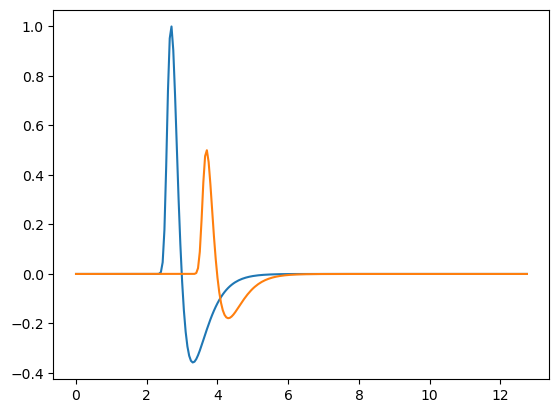

In [5]:
plt.plot(t, mu)
plt.plot(t, td_model((0.5, 1), mu))
plt.show()

## Fits with `costfuntls`

In [6]:
%%time

p_tls = np.empty((2, n_sim))
mu_tls = np.empty((n, n_sim))
resnorm_tls = np.empty((n_sim,))
delta_tls = np.empty((n, n_sim))
epsilon_tls = np.empty((n, n_sim))
cv_tls = np.empty((2, 2, n_sim))
sigma_tls = np.empty((2, n_sim))

for i in range(n_sim):
    sigma_x = noiseamp(sigma_parms, x[i, :], ts)
    sigma_y = noiseamp(sigma_parms, y[i, :], ts)
    result = least_squares(
        lambda _p: costfuntls(
            tf_model, _p[:2], _p[2:], x[i, :], y[i, :], sigma_x, sigma_y, ts
        ),
        np.concatenate((p_opt, x[i, :])),
    )
    p_tls[:, i] = result.x[:2]
    mu_tls[:, i] = result.x[2:]
    delta_tls[:, i] = result.fun[:n]
    epsilon_tls[:, i] = result.fun[n:]
    resnorm_tls[i] = 2 * result.cost
    _, r = np.linalg.qr(result.jac[:, :2])
    r_inv = np.linalg.inv(r)
    cv_tls[:, :, i] = r_inv @ r_inv.T
    sigma_tls[:, i] = np.sqrt(np.diag(cv_tls[:, :, i]))
    if not result.success:
        print(f"Fit did not converge at i = {i}")

cf_tls = cumfreq(resnorm_tls, 1000, defaultreallimits=(0, 1000))
gof_tls = cf_tls.lowerlimit + np.linspace(
    0, cf_tls.binsize * cf_tls.cumcount.size, cf_tls.cumcount.size
)
ecdf_tls = cf_tls.cumcount / n_sim

CPU times: user 9min 15s, sys: 1min 42s, total: 10min 58s
Wall time: 3min 22s


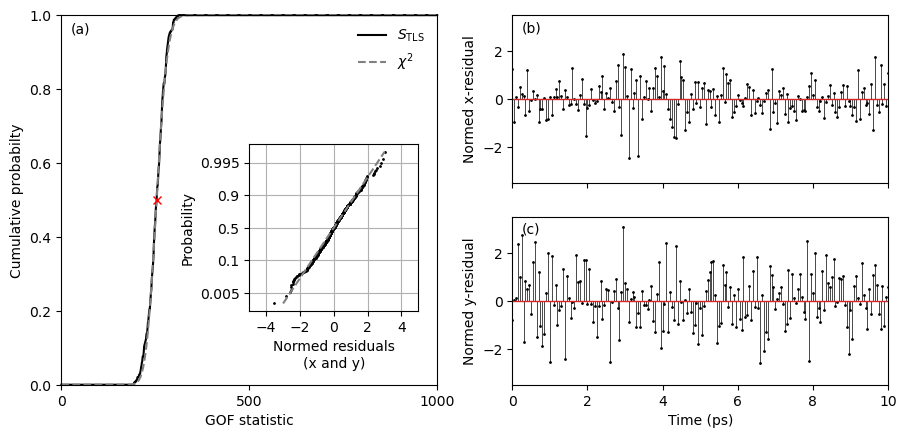

In [7]:
# Find the index of the median value
i_show = np.argsort(resnorm_tls)[len(resnorm_tls) // 2]
norm_res_eps = np.sqrt(512 / 254) * epsilon_tls[:, i_show]
norm_res_delta = np.sqrt(512 / 254) * delta_tls[:, i_show]
osm, osr = probplot(np.concatenate((norm_res_eps, norm_res_delta)), fit=False)

w, h = figaspect(0.45)
_, axd = plt.subplot_mosaic(
    [["CDF", "x-res"], ["CDF", "y-res"]], figsize=(w, h)
)

# Panel (a)
axd["CDF"].plot(
    gof_tls, ecdf_tls, 'k-', label=r'$S_\mathrm{TLS}$', clip_on=False
)
axd["CDF"].plot(
    gof_tls,
    chi2.cdf(gof_tls, n - 2),
    '--',
    c='gray',
    label=r'$\chi^2$',
    clip_on=False,
)
axd["CDF"].plot(np.median(resnorm_tls), 0.5, 'rx')

axd["CDF"].legend(loc='upper right', frameon=False)
axd["CDF"].text(0.025, 0.95, '(a)', transform=axd["CDF"].transAxes)

axd["CDF"].set_xlim(0, 1000)
axd["CDF"].set_ylim(0, 1)

axd["CDF"].set_xticks([0, 500, 1000])
axd["CDF"].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axd["CDF"].set_xlabel('GOF statistic')
axd["CDF"].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axd["CDF"].inset_axes([0.5, 0.2, 0.45, 0.45])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-5, 5)
ins.set_ylim(norm.ppf([0.0005, 0.9995]))

ins.set_xticks(np.arange(-4, 4.5, 2))
ins.set_yticks(norm.ppf([0.005, 0.1, 0.5, 0.9, 0.995]))

ins.set_yticklabels(['0.005', '0.1', '0.5', '0.9', '0.995'])

ins.set_xlabel('Normed residuals\n(x and y)')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axd["x-res"].stem(
    t, norm_res_delta, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["x-res"].text(0.025, 0.9, '(b)', transform=axd["x-res"].transAxes)

axd["x-res"].set_xlim(0, 10)
axd["x-res"].set_ylim(-3.5, 3.5)

axd["x-res"].set_xticklabels([])
axd["x-res"].set_ylabel('Normed x-residual')

# Panel (c)
markerline, stemlines, baseline = axd["y-res"].stem(
    t, norm_res_eps, linefmt='k-', markerfmt='.'
)
markerline.set_markersize(2)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axd["y-res"].text(0.025, 0.9, '(c)', transform=axd["y-res"].transAxes)

axd["y-res"].set_xlim(0, 10)
axd["y-res"].set_ylim(-3.5, 3.5)

axd["y-res"].set_xlabel('Time (ps)')
axd["y-res"].set_ylabel('Normed y-residual')

plt.show()

In [8]:
print(
    f"Amplitude parameter estimates: "
    f"{np.mean(p_tls[0, :]):.3f} ± {np.std(p_tls[0, :]):.3f}"
)
print(
    f"Delay parameter estimates:     "
    f"({np.mean(1e3 * p_tls[1, :]):.1f} ± {1e3 * np.std(p_tls[1, :]):.1f}) fs"
)
print(
    f"Mean uncertainty estimate for amplitude parameter: "
    f"{np.mean(np.sqrt(cv_tls[0, 0, :])):.4f}"
)
print(
    f"Mean uncertainty estimate for delay parameter:     "
    f"{1e3 * np.mean(np.sqrt(cv_tls[1, 1, :])):.1f} fs"
)
print(
    f"Standard deviation of the amplitude parameter uncertainty estimate: "
    f"{np.std(np.sqrt(cv_tls[0, 0, :])):.2g}"
)
print(
    f"Standard deviation of the delay parameter uncertainty estimate:     "
    f"{1e3 * np.std(np.sqrt(cv_tls[1, 1, :])):.2g} fs"
)

Amplitude parameter estimates: 0.500 ± 0.001
Delay parameter estimates:     (1000.0 ± 0.5) fs
Mean uncertainty estimate for amplitude parameter: 0.0008
Mean uncertainty estimate for delay parameter:     0.3 fs
Standard deviation of the amplitude parameter uncertainty estimate: 2.4e-06
Standard deviation of the delay parameter uncertainty estimate:     0.01 fs


## Compare with fits using `costfunlsq`

In [9]:
%%time


def lsq_model(_p, _w):
    return _p[0] * np.exp(1j * _w * _p[1])


p_lsq = np.empty((2, n_sim))
resnorm_lsq = np.empty((n_sim,))
residual_lsq = np.empty((n, n_sim))
cv_lsq = np.empty((2, 2, n_sim))
sigma_lsq = np.empty((2, n_sim))

for i in range(n_sim):
    sigma_x = noiseamp(sigma_parms, x[i, :], ts)
    sigma_y = noiseamp(sigma_parms, y[i, :], ts)
    result = least_squares(
        lambda _p: costfunlsq(
            lsq_model, _p, x[i, :], y[i, :], sigma_x, sigma_y, ts
        ),
        (1, 0),
        jac='2-point',
    )
    p_lsq[:, i] = result.x
    residual_lsq[:, i] = result.fun
    resnorm_lsq[i] = 2 * result.cost
    _, r = np.linalg.qr(result.jac)
    r_inv = np.linalg.inv(r)
    cv_lsq[:, :, i] = r_inv @ r_inv.T
    sigma_lsq[:, i] = np.sqrt(np.diag(cv_lsq[:, :, i]))
    if not result.success:
        print(f"Fit did not converge at i = {i}")

CPU times: user 2h 10min 53s, sys: 19min 17s, total: 2h 30min 11s
Wall time: 41min 12s


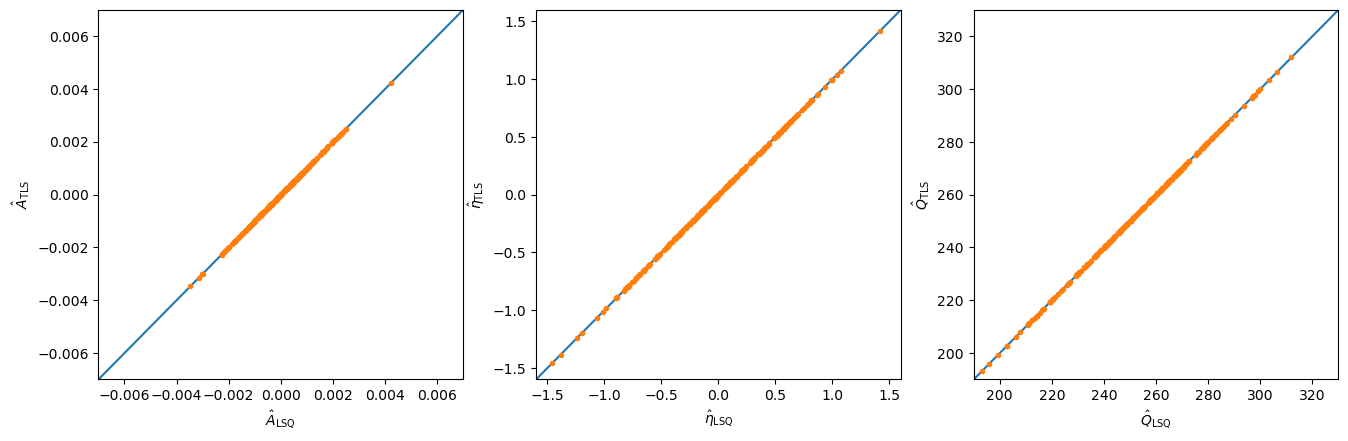

In [10]:
a_lim = (-0.007, 0.007)
eta_lim = (-1.6, 1.6)
q_lim = (190, 330)

w, h = figaspect(0.3)

_, axs = plt.subplots(1, 3, figsize=(w, h))

axs[0].plot(a_lim, a_lim, '-')
axs[0].plot(p_lsq[0, :] - p_opt[0], p_tls[0, :] - p_opt[0], '.')

axs[0].set_xlim(a_lim)
axs[0].set_ylim(a_lim)

axs[0].set_xlabel(r"$\hat{A}_\mathrm{LSQ}$")
axs[0].set_ylabel(r"$\hat{A}_\mathrm{TLS}$")

axs[1].plot(eta_lim, eta_lim, '-')
axs[1].plot(1e3 * (p_lsq[1, :] - p_opt[1]), 1e3 * (p_tls[1, :] - p_opt[1]), '.')

axs[1].set_xlim(eta_lim)
axs[1].set_ylim(eta_lim)

axs[1].set_xlabel(r"$\hat{\eta}_\mathrm{LSQ}$")
axs[1].set_ylabel(r"$\hat{\eta}_\mathrm{TLS}$")

axs[2].plot(q_lim, q_lim, '-')
axs[2].plot(resnorm_lsq, resnorm_tls, '.')

axs[2].set_xlim(q_lim)
axs[2].set_ylim(q_lim)

axs[2].set_xlabel(r"$\hat{Q}_\mathrm{LSQ}$")
axs[2].set_ylabel(r"$\hat{Q}_\mathrm{TLS}$")


plt.show()

### Parameter estimate distributions

The cells below produce probability plots that show the parameter distributions in more detail. Both cost functions yield parameter estimates that are normally distributed around the true values, but the observed distributions with `costfuntls` are narrower than expected. Using `costfunlsq` yields the expected distributions for both parameters.

In [11]:
osm_a_tls, osr_a_tls = probplot(p_tls[0, :], fit=False)
osm_eta_tls, osr_eta_tls = probplot(p_tls[1, :], fit=False)
osm_a_lsq, osr_a_lsq = probplot(p_lsq[0, :], fit=False)
osm_eta_lsq, osr_eta_lsq = probplot(p_lsq[1, :], fit=False)

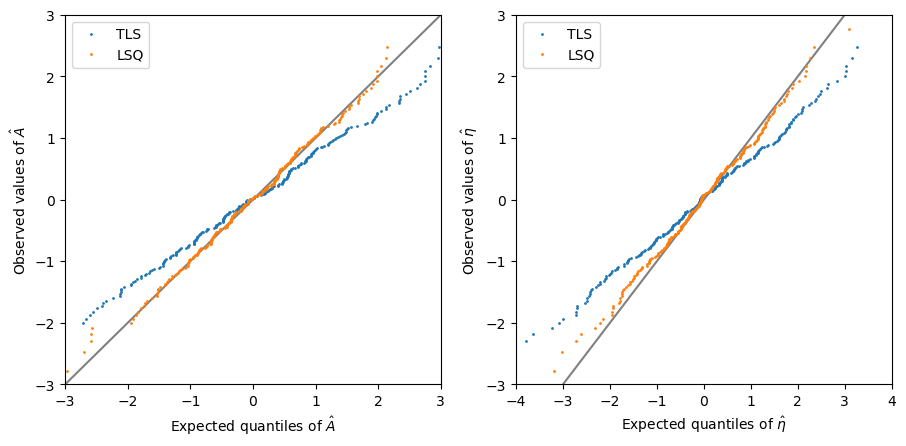

In [12]:
w, h = figaspect(0.45)

_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot((-4.5, 4.5), (-4.5, 4.5), c="gray")
axs[0].plot((osr_a_tls - p_opt[0]) / np.mean(sigma_tls[0, :]), osm_a_tls, '.', ms=2, label=r"TLS")
axs[0].plot((osr_a_lsq - p_opt[0]) / np.mean(sigma_lsq[0, :]), osm_a_lsq, '.', ms=2, label=r"LSQ")
axs[0].legend()

axs[0].set_xlim(-3, 3)
axs[0].set_ylim(-3, 3)

axs[0].set_xlabel(r"Expected quantiles of $\hat{A}$")
axs[0].set_ylabel(r"Observed values of $\hat{A}$")

axs[1].plot((-4.5, 4.5), (-4.5, 4.5), c="gray")
axs[1].plot((osr_eta_tls - p_opt[1]) / np.mean(sigma_tls[1, :]), osm_eta_tls, '.', ms=2, label=r"TLS")
axs[1].plot((osr_eta_lsq - p_opt[1]) / np.mean(sigma_lsq[1, :]), osm_eta_lsq, '.', ms=2, label=r"LSQ")
axs[1].legend()

axs[1].set_xlim(-4, 4)
axs[1].set_ylim(-3, 3)

axs[1].set_xlabel(r"Expected quantiles of $\hat{\eta}$")
axs[1].set_ylabel(r"Observed values of $\hat{\eta}$")

plt.show()

### Parameter uncertainty estimates

The parameter uncertainty estimates obtained with the TLS algorithm exhibit much larger variation than with the LSQ algorithm.

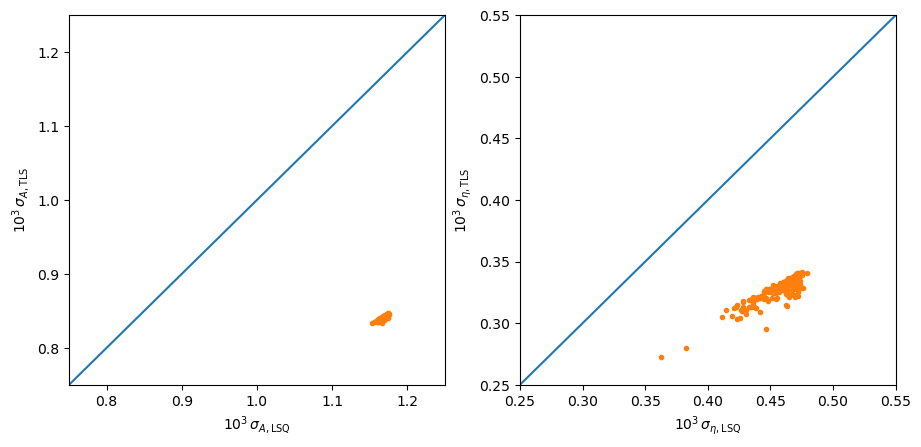

In [13]:
std_a_lim = (0.75, 1.25)
std_eta_lim = (0.25, 0.55)

w, h = figaspect(0.45)

_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(std_a_lim, std_a_lim, '-')
axs[0].plot(1e3 * sigma_lsq[0, :], 1e3 * sigma_tls[0, :], '.')

axs[0].set_xlim(std_a_lim)
axs[0].set_ylim(std_a_lim)

axs[0].set_xlabel(r"$10^3\,\sigma_{A,\mathrm{LSQ}}$")
axs[0].set_ylabel(r"$10^3\,\sigma_{A,\mathrm{TLS}}$")

axs[1].plot(std_eta_lim, std_eta_lim, '-')
axs[1].plot(1e3 * sigma_lsq[1, :], 1e3 * sigma_tls[1, :], '.')

axs[1].set_xlim(std_eta_lim)
axs[1].set_ylim(std_eta_lim)

axs[1].set_xlabel(r"$10^3\,\sigma_{\eta,\mathrm{LSQ}}$")
axs[1].set_ylabel(r"$10^3\,\sigma_{\eta,\mathrm{TLS}}$")

plt.show()

## Compare results for a single typical simulation

The cells below show that the two cost functions are slightly different, which may explain the differences between the parameter estimates obtained from the two algorithms.

In [14]:
i = i_show
print(f"theta_lsq = {p_lsq[:, i]}")
print(f"theta_tls = {p_tls[:, i]}")
print(f"Q_lsq(theta_lsq) = {resnorm_lsq[i]}")
print(f"Q_tls(theta_tls) = {resnorm_tls[i]}")

theta_lsq = [0.49948458 1.00013637]
theta_tls = [0.49948477 1.00013604]
Q_lsq(theta_lsq) = 254.6921625619372
Q_tls(theta_tls) = 254.69216287614304


In [15]:
sigma_x = noiseamp(sigma_parms, x[i, :], ts)
sigma_y = noiseamp(sigma_parms, y[i, :], ts)

w = 2 * np.pi * rfftfreq(n, ts)
h_f = np.conj(lsq_model(p_tls[:, i], w))

h_imp = irfft(h_f, n=n)
h = la.circulant(h_imp)
uy = h @ ((sigma_x**2) * h).T
inv_uy = la.inv(uy)
inv_vy = np.diag(1 / sigma_y**2)
mu_hat = (
    la.inv(h)
    @ la.inv(inv_uy + inv_vy)
    @ (inv_uy @ h @ x[i, :] + inv_vy @ y[i, :])
)
psi_hat = h @ mu_hat

q_tls_theta_lsq = np.sum(((y[i, :] - psi_hat) / sigma_y) ** 2) + np.sum(
    ((x[i, :] - mu_hat) / sigma_x) ** 2
)
q_tls_theta_tls = np.sum(
    ((y[i, :] - td_model(p_tls[:, i], mu_tls[:, i])) / sigma_y)
    ** 2
) + np.sum(((x[i, :] - mu_tls[:, i]) / sigma_x) ** 2)

q_lsq_theta_lsq = np.sum(
    costfunlsq(lsq_model, p_lsq[:, i], x[i, :], y[i, :], sigma_x, sigma_y, ts)
    ** 2
)
q_lsq_theta_tls = np.sum(
    costfunlsq(lsq_model, p_tls[:, i], x[i, :], y[i, :], sigma_x, sigma_y, ts)
    ** 2
)
print(f"Output: Q_lsq(theta_lsq) = {resnorm_lsq[i]}")
print(f"Direct: Q_lsq(theta_lsq) = {q_lsq_theta_lsq}")

print(f"Output: Q_tls(theta_tls) = {resnorm_tls[i]}")
print(f"Direct: Q_tls(theta_tls) = {q_tls_theta_tls}")

print(f"Direct: Q_tls(theta_lsq) = {q_tls_theta_lsq}")
print(f"Direct: Q_lsq(theta_tls) = {q_lsq_theta_tls}")

Output: Q_lsq(theta_lsq) = 254.6921625619372
Direct: Q_lsq(theta_lsq) = 254.69216256193724
Output: Q_tls(theta_tls) = 254.69216287614304
Direct: Q_tls(theta_tls) = 254.69216287614304
Direct: Q_tls(theta_lsq) = 254.69216274223618
Direct: Q_lsq(theta_tls) = 254.69216274222282


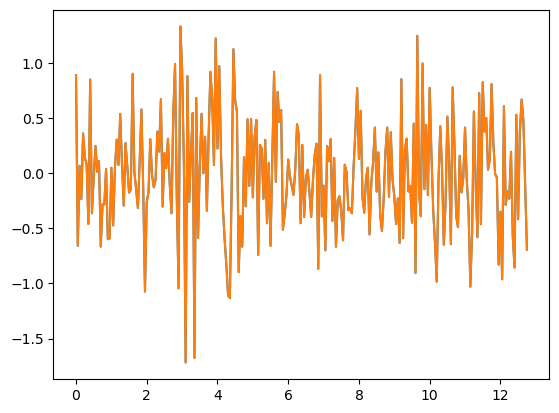

In [16]:
_, ax = plt.subplots()
ax.plot(t, delta_tls[:, i])
ax.plot(t, (x[i, :] - mu_hat) / sigma_x)
plt.show()

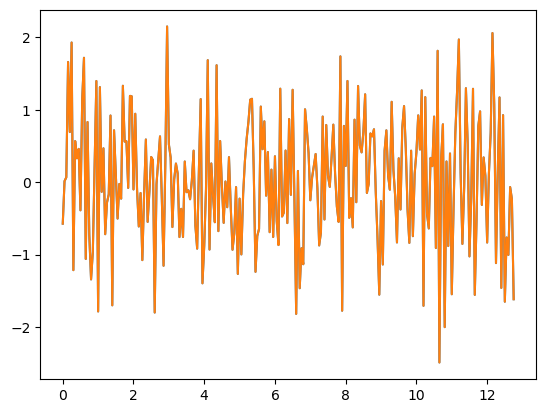

In [17]:
_, ax = plt.subplots()
ax.plot(
    t, (y[i, :] - td_model(p_tls[:, i], mu_tls[:, i])) / sigma_y
)
ax.plot(t, (y[i, :] - psi_hat) / sigma_y)
plt.show()

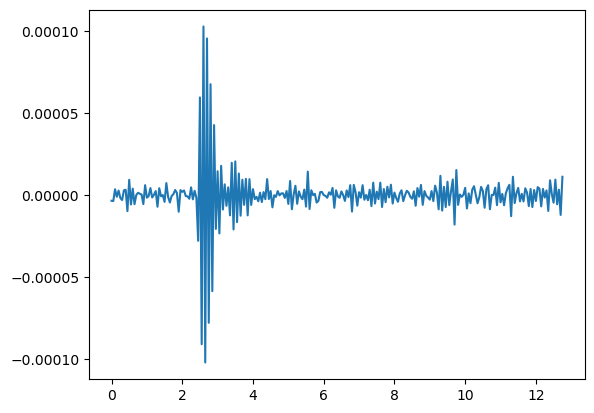

In [18]:
_, ax = plt.subplots()
ax.plot(t, delta_tls[:, i] - (x[i, :] - mu_hat) / sigma_x)
plt.show()

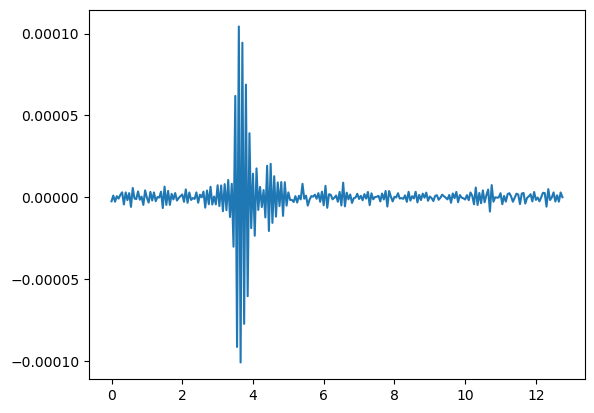

In [19]:
_, ax = plt.subplots()
ax.plot(
    t,
    (y[i, :] - td_model(p_tls[:, i], mu_tls[:, i])) / sigma_y
    - (y[i, :] - psi_hat) / sigma_y,
)
plt.show()